In [1]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn_deltatfidf import DeltaTfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from matplotlib import pyplot as plt
%matplotlib inline

# Data loading

In [117]:
def get_embeddings(wv_file='wiki.ru.vec'):
    return gensim.models.KeyedVectors.load_word2vec_format(wv_file)

In [6]:
def get_words_to_score(embeddings, max_num=10000):
    words = pd.read_csv('freqrnc2011.csv', sep='\t').sort_values('Freq(ipm)', ascending=False)
    top_words = list(
        set(filter(lambda x: x in embeddings, [x.lower() for x in words[:max_num]['Lemma'].to_numpy()]))
    )
    return top_words

In [115]:
embeddings = get_embeddings()
embeddings.iw = get_words_to_score(embeddings)

In [119]:
embeddings_mm = gensim.models.Word2Vec.load('ModelMM.vec')
embeddings_mm.iw = embeddings.iw

# Seeds

In [8]:
positive_seeds_general = [
    "хороший", "прекрасный", "счастливый", "улучшение", "прогресс", "успех", "добро"
]
negative_seeds_general = [
    "ненависть", "ужасный", "несчастный", "трагедия", "плохой", "зло",
    "смерть", "ухудшение", "коррупция", "преступление"
]
positive_seeds_kz = [
    'развитие', 'проект', 'программа', 'производство', 'инвестиция',
    'создавать', 'возможность', 'отрасль', 'подписывать', 'модернизация',
    'реализовывать', 'достигать', 'смочь', 'перспектива', 'рождаться'
]
negative_seeds_kz = [
    'отключение', 'незаконно', 'погибать', 'вынуждать', 'преступник',
    'заставлять', 'враг', 'вор', 'ослабление', 'залог',
    'взяточничество', 'махинация', 'поймать', 'халатность',
    'экстремистский', 'избивать', 'угрожать'
]

In [9]:
positive_seeds = positive_seeds_general + positive_seeds_kz
negative_seeds = negative_seeds_general + negative_seeds_kz

# Words scoring

In [10]:
def get_edge_matrix(embeddings, k=25):
    A = np.array([embeddings[word] for word in embeddings.iw])
    T = cosine_similarity(A)
    T = np.arccos(np.clip(-T, -1, 1)) / np.pi
    def knn(vec, k=k):
        vec[vec < np.sort(vec)[-k]] = 0.
    np.fill_diagonal(T, 0)
    np.apply_along_axis(knn, 1, T)
    return T

In [11]:
#@lru_cache(maxsize=1, typed=False)
def transition_matrix(embeddings):
    edge_matrix = get_edge_matrix(embeddings)
    scale_matrix = np.diag([1. / np.sqrt(edge_matrix[i].sum())
                            if edge_matrix[i].sum() > 0. else 0.
                            for i in range(edge_matrix.shape[0])])
    return np.dot(scale_matrix, np.dot(edge_matrix, scale_matrix))

In [12]:
def run_walk(tr_matrix, pol_vector, beta, max_iter, eps):
    loss = 0
    vector = np.ones(tr_matrix.shape[0]) / tr_matrix.shape[0]
    for i in range(max_iter):
        new_vector = beta * np.dot(tr_matrix, vector) + (1 - beta) * pol_vector
        loss = np.abs(new_vector - vector).sum()
        if loss < eps:
            break
        vector = new_vector
    return vector

In [13]:
def get_walk_start_vector(words, seeds):
    return np.array([seeds[word] if word in seeds else 0.0 for word in words]) / len(seeds)

In [14]:
def random_walk(embeddings, positive_seeds, negative_seeds, beta=0.9, max_iter=1000, eps=1e-6):
    if not type(positive_seeds) == dict:
        positive_seeds = {word: 1.0 for word in positive_seeds}

    if not type(negative_seeds) == dict:
        negative_seeds = {word: 1.0 for word in negative_seeds}

    words = embeddings.iw
    tr_matrix = transition_matrix(embeddings)
    pos_pol = run_walk(tr_matrix, get_walk_start_vector(words, positive_seeds), beta, max_iter, eps)
    neg_pol = run_walk(tr_matrix, get_walk_start_vector(words, negative_seeds), beta, max_iter, eps)
    score = {w: pos_pol[i] / (neg_pol[i] + pos_pol[i]) if neg_pol[i] + pos_pol[i] > 0 else 0 for i, w in enumerate(words)}
    return pos_pol, neg_pol, score

In [15]:
pos_pol, neg_pol, word_scores = random_walk(embeddings, positive_seeds, negative_seeds)

### Kazakhstan

In [17]:
def get_kz_text():
    mystem = Mystem() 
    russian_stopwords = stopwords.words("russian")
    
    def preprocess_text(text):
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation
                  and token in embeddings]

        text = " ".join(tokens)
        return text
    
    with open('train.json') as f:
        kz = json.load(f)
        
    kpos = list(map(lambda x: preprocess_text(x['text']), filter(lambda x: x['sentiment'] == 'positive', kz)))
    kneg = list(map(lambda x: preprocess_text(x['text']), filter(lambda x: x['sentiment'] == 'negative', kz)))
    texts = list(map(lambda x: preprocess_text(x['text']), kz))
    return kpos, kneg, texts

def get_words_stat(kpos, kneg):
    pos_words = ' '.join(kpos).split(' ')
    neg_words = ' '.join(kneg).split(' ')
    pos_cnt = Counter(pos_words)
    neg_cnt = Counter(neg_words)
    word_score = dict()
    for word in set(pos_words + neg_words):
        word_score[word] = pos_cnt[word] - neg_cnt[word]
    return words_score

In [23]:
kpos, kneg, kall = get_kz_text()

# Mediametrics

In [120]:
def get_mm_texts(filename):
    return pd.read_csv(filename)

mm_data = get_mm_texts('mm_v2.csv')
mm_data_reg = get_mm_texts('mm.csv')

In [133]:
mm_dreg = defaultdict(list)
for ind, text in enumerate(mm_data.iloc[:,1].to_numpy()):
    mm_dreg[mm_data_reg.iloc[ind, 7]].append(text)

# News scoring

In [109]:
def get_dtfidf(kpos, kneg):
    data = kpos + kneg
    labels = [1] * len(kpos) + [-1] * len(kneg)
    v = DeltaTfidfVectorizer()
    v.fit(data, labels)
    return dict([(w, v.idf_[i]) for w, i in v.vocabulary_.items()])

In [26]:
def get_tfidf(kpos, kneg=[]):
    tfidf = TfidfVectorizer()
    tfidf.fit(kpos + kneg)
    return dict([(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

In [27]:
tfidf = get_tfidf(kall)

In [110]:
dtfidf = get_dtfidf(kpos, kneg)

In [85]:
def get_text_score(text, wrd_scores=None, w=None):
    if word_scores is None:
        wrd_scores = word_scores
    score = 0
    cnt = 0
    for word in text.split():
        if word in word_scores:
            if w is None:
                score += word_scores[word]
                cnt += 1
            elif word in w:
                score += word_scores[word] * w[word]
                cnt += 1
    return score / cnt if cnt > 0 else 0

In [86]:
def get_scores(texts, word_scores=None, w=None):
    scores = dict()
    for i, text in enumerate(texts):
        scores[i] = get_text_score(text, word_scores, w=w)
    return scores

In [102]:
def analyze_texts(texts, top_pos=10, top_neg=10, word_scores=None, w=None):
    scores = get_scores(texts, word_scores, w=w)
    scores_sorted = list(sorted(scores.items(), key=lambda x: x[1]))
    sns.distplot(list(scores.values()))
    return scores, scores_sorted[:top_neg], scores_sorted[-top_pos:]

In [88]:
def compare_scores(first, second,  word_scores=None, w=None):
    analyze_texts(first, word_scores=word_scores, w=w)
    analyze_texts(second, word_scores=word_scores, w=w)
    plt.show()

In [144]:
mm_scores = defaultdict(np.array)

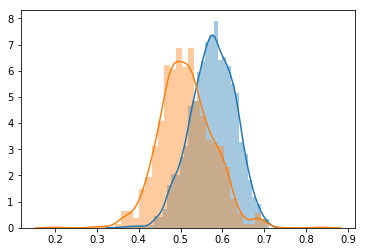

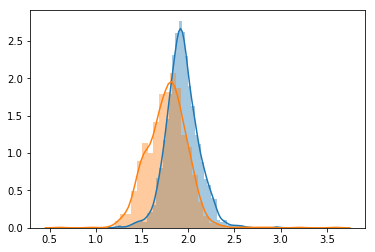

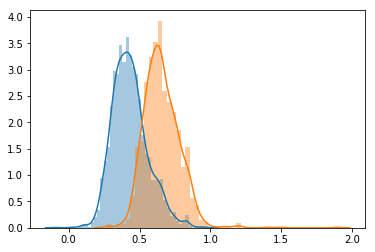

In [111]:
compare_scores(kpos, kneg)
compare_scores(kpos, kneg, w=tfidf)
compare_scores(kpos, kneg, w=dtfidf)

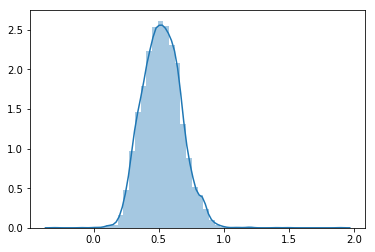

In [112]:
_, neg, pos = analyze_texts(kall, w=dtfidf)

In [113]:
print('POS:')
for text, score in pos:
    print(score)
    print(kall[text][:100])
    
print('NEG:')

for text, score in neg:
    print(score)
    print(kall[text][:100])

POS:
1.0780647852589207
приобретать облигация тоо аурум сумма пять миллиард тенге биржа kase счет собственный средство факт 
1.101236317327119
признаваться многомиллиардный убыток признаваться многомиллиардный убыток
1.128968782731055
s p понижать рейтинг ктж вв прогноз негативный платный подписчик авторизация
1.1823167208087062
арестовывать руководство единый накопительный пенсионный фонд facebook
1.1966909190395332
дкнб алматы провожать досудебный расследование факт сделка облигация тоо аурум добавлять й абзац
1.2015115770417697
представлять скудный подробность
1.2113866659536252
причина расследование факт сделка заявление нацбанк facebook
1.4081682464278047
дкнб алматы расследовать сделка млрд тенге facebook
1.4938917431602832
подробность проверка обнародоваться нацбанк facebook
1.896050261888175
рк пожаловаться фейковый аккаунт соцсеть facebook
NEG:
-0.2971657839719536
флагман каспийский флотилия ракетный корабль татарстан град свияжск входить порт актау дружественный
-0.0875118823